In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from shapely.geometry import Polygon

os.chdir('/home/gptrapletti/ds/satellite-multiclass-segm')

# <ins> FUNCTION TO TURN MASK PNGS TO SEMANTIC MASK ARRAYS

In [3]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [11]:
mask = cv2.imread(mask_filepaths[55])
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

mask.shape

(4000, 6000, 3)

In [12]:
category_colors = {
'background': [(112, 150, 146),
  (2, 135, 115),
  (9, 143, 150),
  (0, 0, 0),
  (119, 11, 32),
  (102, 51, 0),
  (255, 0, 0),
  (190, 153, 153),
  (0, 50, 89),
  (153, 153, 153)],
 'ground': [(128, 64, 128), (112, 103, 87), (130, 76, 0), (48, 41, 30)],
 'vegetation': [(0, 102, 0), (107, 142, 35), (51, 51, 0), (190, 250, 190)],
 'buildings': [(70, 70, 70), (102, 102, 156), (254, 228, 12), (254, 148, 12)],
 'water': [(28, 42, 168)],
 'person': [(255, 22, 96)]}

category_ids = {
    'background': 0,
    'ground': 1,
    'vegetation': 2,
    'buildings': 3,
    'water': 4,
    'person': 5
}

In [13]:
b = np.all(mask == [128, 64, 128], axis=2)
b.shape

(4000, 6000)

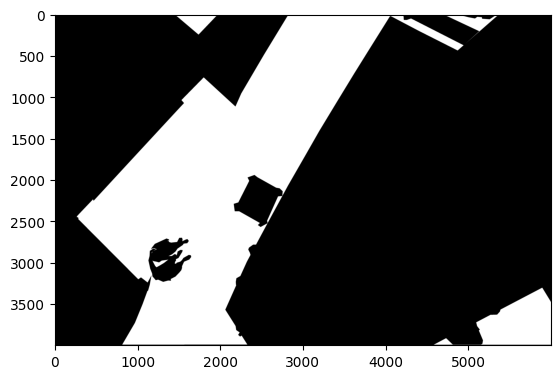

In [14]:
plt.imshow(b, cmap='gray')

In [15]:
for category in category_colors:
    for color in category_colors[category]:
        color_is_present = np.all(mask == color, axis=2)
        mask[color_is_present] = category_ids[category]      

In [54]:
mask.shape

(4000, 6000, 3)

In [55]:
np.unique(mask)

array([0, 1, 2, 3, 5], dtype=uint8)

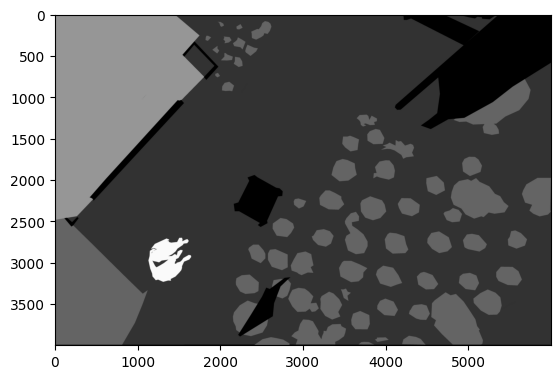

In [18]:
plt.imshow(mask * 50)

In [19]:
np.all(mask[..., 1] == mask[..., 2])

True

In [20]:
np.unique(mask).tolist()

[0, 1, 2, 3, 5]

## TEST IF DATALOADER'S NUM_WORKERS MAY HELP INSTEAD OF USING LIBRARY MULTIPROCESSING

In [4]:
from src.utils import from_png_to_semantic_mask

In [33]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, mask_filepaths):
        super().__init__()
        self.mask_filepaths = mask_filepaths
        
    def __len__(self):
        return len(self.mask_filepaths)
    
    def __getitem__(self, idx):
        mask_filepath = self.mask_filepaths[idx]
        mask = cv2.imread(mask_filepath)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        semantic_mask = from_png_to_semantic_mask(mask)
        return semantic_mask

In [56]:
dataset = MyDataset(mask_filepaths=mask_filepaths[:10])

dataset[0].shape

(6000, 3)

In [51]:
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=0)

In [ ]:
for batch in tqdm(dataloader):
    continue

In [53]:
batch.shape

torch.Size([1, 6000, 3])

# <INS> FIND OUT IF DATASET CAN RETURN SINGLE PATCHES

In [65]:
# It doesn't work this way
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = list(range(1, 10+1))

    def __getitem__(self, index):
        number = self.data[index]
        for i in range(1, 5+1):
            patch = number + i/10
            return patch
            

    def __len__(self):
        return len(self.data)*10
    
dataset = DummyDataset()

mylist = list(dataset)

mylist

[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1]

In [76]:
# To simulate computing bounding boxes coordinates before hand and then return a single patch
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = list(range(1, 10+1))
        self.bounding_boxes = self.get_elements(self.data) 

    def __getitem__(self, index):
        return self.bounding_boxes[index]
            
    def get_elements(self, data):
        l = []
        for d in data:
            for i in range(1, 5+1):
                l.append(d + i/10)
        
        return l

    def __len__(self):
        return len(self.data)
    
dataset = DummyDataset()

mylist = list(dataset)

mylist

[1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 3.1,
 3.2,
 3.3,
 3.4,
 3.5,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 5.1,
 5.2,
 5.3,
 5.4,
 5.5,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5,
 7.1,
 7.2,
 7.3,
 7.4,
 7.5,
 8.1,
 8.2,
 8.3,
 8.4,
 8.5,
 9.1,
 9.2,
 9.3,
 9.4,
 9.5,
 10.1,
 10.2,
 10.3,
 10.4,
 10.5]

Let's try it with the satellite data

In [ ]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [77]:
image = torch.rand((3, 1500, 2000))

image.shape

torch.Size([3, 1500, 2000])

In [295]:
def get_random_bbox_coords(side, max_height, max_width):
    top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
    bottom_right = top_left[0] + side, top_left[1] + side
    return (top_left, bottom_right)

In [119]:
# Too slow! For every patch the image is loaded again
class MyDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_filepaths,
    ):
        super().__init__()
        self.image_filepaths = image_filepaths
        self.n_patch_per_image = 100
        self.patch_bboxs = self.generate_patch_bboxs()
           
    def get_random_bbox_coords(self, side, max_height, max_width):
        top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
        bottom_right = top_left[0] + side, top_left[1] + side
        return (top_left, bottom_right)
    
    def generate_patch_bboxs(self):
        patch_bboxs = []
        for i in range(len(self.image_filepaths)):
            for j in range(self.n_patch_per_image):
                filepath = image_filepaths[i]
                bbox = self.get_random_bbox_coords(side=256, max_height=2000, max_width=3000)
                patch_bboxs.append((filepath, bbox))
        
        return patch_bboxs
                
    def __getitem__(self, idx):
        filepath = self.patch_bboxs[idx][0]
        bbox = self.patch_bboxs[idx][1]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (3000, 2000)) # cv2 wants tuple (width, height)
        patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
        return patch

    def __len__(self):
        return len(self.patch_bboxs)

In [120]:
dataset = MyDataset(image_filepaths=image_filepaths[:300])
len(dataset.patch_bboxs)

30000

4574 (256, 256, 3)


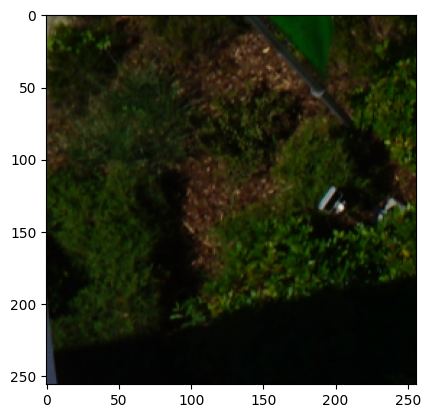

In [112]:
idx = random.randint(0, len(dataset)-1)
a = dataset[idx]
print(idx, a.shape)

plt.imshow(a)

In [ ]:
for i in tqdm(range(len(dataset))):
    patch = dataset[i]
    
# 2h 45min

In [116]:
# Cached version
from collections import OrderedDict

class MyCachedDataset(torch.utils.data.Dataset):
    def __init__(self, image_filepaths, cache_size=10):
        super().__init__()
        self.image_filepaths = image_filepaths
        self.n_patch_per_image = 100
        self.patch_bboxs = self.generate_patch_bboxs()
        self.cache_size = cache_size
        self.image_cache = OrderedDict()

    def get_random_bbox_coords(self, side, max_height, max_width):
        top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
        bottom_right = top_left[0] + side, top_left[1] + side
        return (top_left, bottom_right)
    
    def generate_patch_bboxs(self):
        patch_bboxs = []
        for i in range(len(self.image_filepaths)):
            for j in range(self.n_patch_per_image):
                filepath = image_filepaths[i]
                bbox = self.get_random_bbox_coords(side=256, max_height=2000, max_width=3000)
                patch_bboxs.append((filepath, bbox))
        
        return patch_bboxs

    def load_and_process_image(self, filepath):
        if filepath in self.image_cache:
            # Return cached image if it's in the cache
            image = self.image_cache[filepath]
            # Move the accessed entry to the end (to show it's recently used)
            self.image_cache.move_to_end(filepath)
        else:
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (3000, 2000))
            
            # Add the loaded image to the cache
            self.image_cache[filepath] = image
            
            # If cache exceeds size limit, remove the least recently used item (first item)
            if len(self.image_cache) > self.cache_size:
                self.image_cache.popitem(last=False)
        
        return image

    def __getitem__(self, idx):
        filepath = self.patch_bboxs[idx][0]
        bbox = self.patch_bboxs[idx][1]
        image = self.load_and_process_image(filepath)
        patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
        return patch
    
    def __len__(self):
        return len(self.patch_bboxs)

In [117]:
dataset = MyCachedDataset(image_filepaths=image_filepaths[:300])
len(dataset.patch_bboxs)

30000

In [118]:
for i in tqdm(range(len(dataset))):
    patch = dataset[i]
    
# cached = 1m40s

100%|██████████| 30000/30000 [01:40<00:00, 298.07it/s]


# <ins> GRID SLICING

Function to find bounding box coordinates for patches extracting along a grid.

In [271]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [272]:
image = np.random.rand(2000, 3000, 3)
image.shape

(2000, 3000, 3)

In [273]:
side = 256
overlap = 128
max_height = 2000
max_width = 3000

In [274]:
side = 256
overlap = 0.5
max_height = 2000
max_width = 3000

increment = side - int(side*overlap)
bboxs = []
bbox_reference = ((0, 0), (256, 256))
bboxs.append(bbox_reference)

# While there is still space along the height
while bboxs[-1][1][0] < max_height:
    # While there is still space along the width
    while max_width - bboxs[-1][1][1] > increment:
        top_left = (bboxs[-1][0][0], bboxs[-1][0][1] + increment)
        bottom_right = (bboxs[-1][1][0], bboxs[-1][1][1] + increment)
        new_bbox = (top_left, bottom_right)
        bboxs.append(new_bbox)
    else:
        # If last bbox along the width tells use there is still space for one more row along the height
        if max_height - bboxs[-1][1][0] > increment:
            # Start a new row
            bbox_reference = ( (bbox_reference[0][0]+increment, bbox_reference[0][1]), (bbox_reference[1][0]+increment, bbox_reference[1][1]) )
            bboxs.append(bbox_reference)
        else:
            break
        
len(bboxs)

308

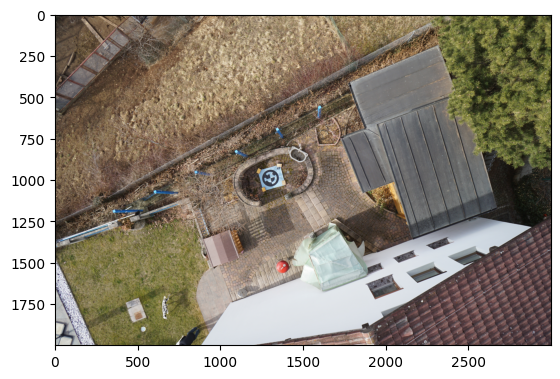

In [276]:
# Plot an image
image = cv2.imread(image_filepaths[54])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (3000, 2000))

plt.imshow(image)
plt.show()

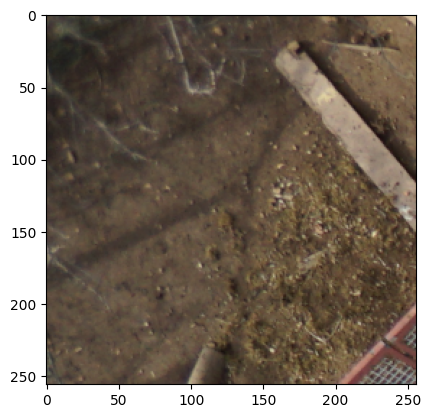

In [160]:
# Plot a patch
bbox = bboxs[0]
patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]

plt.imshow(patch)
plt.show()

In [ ]:
# Plot all patches
n = 22
loc = 0

for i in range(int(len(bboxs)/n)):
    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):    
        bbox = bboxs[loc]
        axs[i].imshow(image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :])
        axs[i].axis('off')
        loc += 1

Version where, if there is not space for another patch, a patch is cropped from the end of the image, going backwards.

In [255]:
side = 256
overlap = 0.50
max_height = 2000
max_width = 3000

stride = side - int(side*overlap)
n_bboxs_along_height = 1 + ((max_height - side) // stride)
n_bboxs_along_width = 1 + ((max_width - side) // stride)
print(n_bboxs_along_height, n_bboxs_along_width)

bboxs = []
bbox_reference = ((0, 0), (256, 256))
bboxs.append(bbox_reference)

for i in range(n_bboxs_along_height): ### ! +1 for the last row (manual)
    
    for j in range(n_bboxs_along_width -1): # -1?
        top_left = (bboxs[-1][0][0], bboxs[-1][0][1] + stride)
        bottom_right = (bboxs[-1][1][0], bboxs[-1][1][1] + stride)
        new_bbox = (top_left, bottom_right)
        bboxs.append(new_bbox)
        
    last_bbox = ( (bboxs[-1][0][0], max_width - side), (bboxs[-1][1][0], max_width) )
    bboxs.append(last_bbox)
       
    bbox_reference = ( (bbox_reference[0][0]+stride, bbox_reference[0][1]), (bbox_reference[1][0]+stride, bbox_reference[1][1]) )
    bboxs.append(bbox_reference)

# Remove last boox for it is out of bounds.
bboxs = bboxs[:-1] 

# Do last row (from the end of the height)
bbox_start = ( (max_height - side, 0), (max_height, side) )
bboxs.append(bbox_start)

for j in range(n_bboxs_along_width -1):
    top_left = (bboxs[-1][0][0], bboxs[-1][0][1] + stride)
    bottom_right = (bboxs[-1][1][0], bboxs[-1][1][1] + stride)
    new_bbox = (top_left, bottom_right)
    bboxs.append(new_bbox)

last_bbox = ( (bboxs[-1][0][0], max_width - side), (bboxs[-1][1][0], max_width) )
bboxs.append(last_bbox)

len(bboxs)

14 22


345

In [ ]:
# Plot patches
n = 23
loc = 0

for i in range(n_bboxs_along_height + 1):
    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):    
        bbox = bboxs[loc]
        axs[i].imshow(image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :])
        axs[i].axis('off')
        loc += 1
        

In [253]:
# Actually extract patches
patches = []

for bbox in tqdm(bboxs):
    patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
    patches.append(patch)
    
# Shape check
print(set([patch.shape for patch in patches]))

100%|██████████| 345/345 [00:00<00:00, 607742.49it/s]


# <ins> PNG PARTIAL LOADING TEST

In [277]:
import PIL

In [287]:
with PIL.Image.open(image_filepaths[27]) as image:
    patch = np.array(image.crop((100, 200, 300, 400)))
    
patch.shape

(200, 200, 3)

# <ins> CHECK PATCH SIZE VS IMAGE SIZE

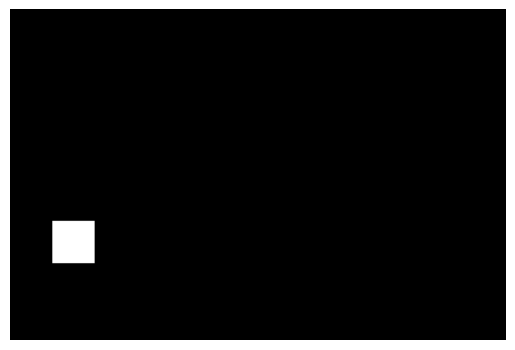

In [293]:
image = np.zeros(shape=(2000, 3000))
bbox = bboxs[222]
image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

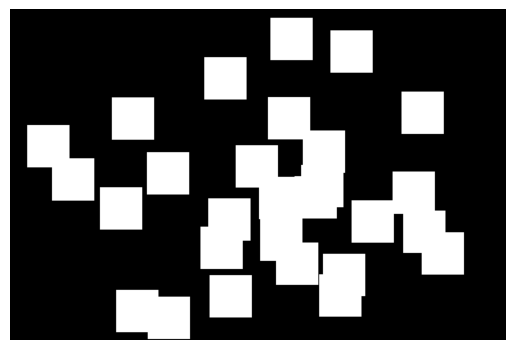

In [332]:
image = np.zeros(shape=(2000, 3000))
n_patches = 28

bboxs = [get_random_bbox_coords(side=256, max_height=2000, max_width=3000) for i in range(n_patches)]

for bbox in bboxs:
    image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

Let's try to not return bboxs that overlap with others.

5


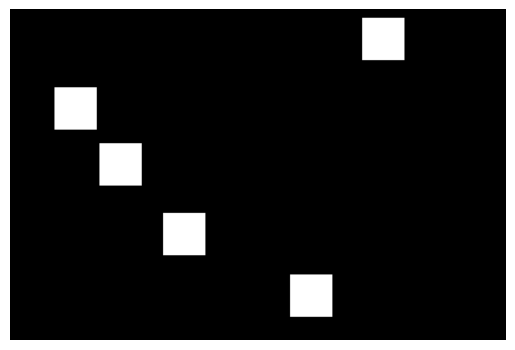

In [465]:
# It works but every patch defines a cross upon which there can't be other patches.
bboxs = []

for i in range(1000):
    bbox_i = get_random_bbox_coords(side=256, max_height=2000, max_width=3000)
    if len(bboxs) == 0:
        bboxs.append(bbox_i)
    else:
        checks = 0
        for bbox in bboxs:
            # Check if bbox_i is not overlapping
            height_check = bbox_i[0][0] > bbox[1][0] or bbox_i[1][0] < bbox[0][0]
            width_check = bbox_i[0][1] > bbox[1][1] or bbox_i[1][1] < bbox[0][1]
            if height_check and width_check:
                checks += 1
        if checks == len(bboxs):
            bboxs.append(bbox_i)
                          
print(len(bboxs))



image = np.zeros(shape=(2000, 3000))

for bbox in bboxs:
    image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()    

In [488]:
def shapely_friendly_bbox(bbox):
    return (bbox[0], (bbox[0][0], bbox[1][1]), bbox[1], (bbox[1][0], bbox[0][1]))

28


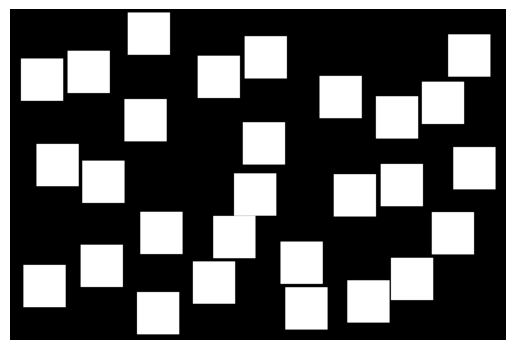

In [559]:
# Shapely version
bboxs = []

for i in range(100):
    bbox_i = get_random_bbox_coords(side=256, max_height=2000, max_width=3000)
    if len(bboxs) == 0:
        bboxs.append(bbox_i)
    else:
        is_overlapping = False
        bbox_i_polygon = Polygon(shapely_friendly_bbox(bbox_i))
        for bbox in bboxs:
            bbox_polygon = Polygon(shapely_friendly_bbox(bbox))
            intersection = bbox_i_polygon.intersects(bbox_polygon)
            if intersection:
                is_overlapping = True
                break
        if not is_overlapping:
            bboxs.append(bbox_i)

                          
print(len(bboxs))



image = np.zeros(shape=(2000, 3000))

for bbox in bboxs:
    image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()    

In [466]:
bboxs

[((1232, 926), (1488, 1182)),
 ((811, 541), (1067, 797)),
 ((473, 269), (729, 525)),
 ((53, 2130), (309, 2386)),
 ((1604, 1694), (1860, 1950))]

In [472]:
list(bboxs[1])

[(811, 541), (1067, 797)]

In [497]:
bbox1 = Polygon(shapely_friendly_bbox(bboxs[1]))
bbox2 = Polygon(shapely_friendly_bbox(bboxs[2]))

bbox1.intersects(bbox2)

False